In [8]:
import numpy as np 
import os
import pandas as pd 
from scipy.io import wavfile

import librosa
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from tensorflow.keras import regularizers, activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from datetime import datetime 

from matplotlib import pyplot as plt

# Importation des données

In [3]:
us8k_df = pd.read_pickle("us8k_df.pkl")

In [4]:
df = us8k_df.drop(['fold'],axis=1)
df['melspectrogram'][0]

array([[-61.70703 , -74.49714 , -65.133354, ..., -80.      , -80.      ,
        -80.      ],
       [-58.9729  , -65.05351 , -65.055664, ..., -80.      , -80.      ,
        -80.      ],
       [-58.314186, -59.996964, -61.480446, ..., -80.      , -80.      ,
        -80.      ],
       ...,
       [-80.      , -80.      , -67.451935, ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -74.46571 , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

In [7]:
X = np.stack(df.melspectrogram.to_numpy())

X_dim = (128,128,1)
X = X.reshape(X.shape[0], *X_dim)
Y = np.array(df['label'])
Y = to_categorical(Y)

In [10]:
def init_data_aug():
    train_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode = 'constant',
        cval=-80.0,
        width_shift_range=0.1,
        height_shift_range=0.0)

    val_datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        fill_mode = 'constant',
        cval=-80.0)
    
    
    return train_datagen, val_datagen

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,shuffle=True,stratify = Y)
len(X_train),len(X_test),len(Y_test)
X_val, X_test, Y_val,Y_test = train_test_split(X_test,Y_test,test_size=0.5,shuffle=True,stratify = Y_test)
len(X_test)

1310

In [13]:
def init_model():
    model1 = Sequential()
    
    #layer-1
    model1.add(Conv2D(filters=24, kernel_size=5, input_shape=(128, 128, 1),
                      kernel_regularizer=regularizers.l2(1e-3)))
    model1.add(MaxPooling2D(pool_size=(3,3), strides=3))
    model1.add(Activation(activations.relu))
    
    #layer-2
    model1.add(Conv2D(filters=36, kernel_size=4, padding='valid', kernel_regularizer=regularizers.l2(1e-3)))
    model1.add(MaxPooling2D(pool_size=(2,2), strides=2))
    model1.add(Activation(activations.relu))
    
    #layer-3
    model1.add(Conv2D(filters=48, kernel_size=3, padding='valid'))
    model1.add(Activation(activations.relu))
    
    model1.add(GlobalAveragePooling2D())
    
    #layer-4 (1st dense layer)
    model1.add(Dense(60, activation='relu'))
    model1.add(Dropout(0.5))
    
    #layer-5 (2nd dense layer)
    model1.add(Dense(10, activation='softmax'))

    
    # compile
    model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model1

In [15]:
def process(model,X_train,X_val,Y_train,Y_val, epochs=100, num_batch_size=32):
    
    # init model
    model = init_model()
    
    train_datagen, val_datagen = init_data_aug()
    # fit augmentation
    train_datagen.fit(X_train)
    val_datagen.fit(X_train)


    # pre-training accuracy
    score = model.evaluate(val_datagen.flow(X_val, Y_val, batch_size=num_batch_size), verbose=0)
    print("Pre-training accuracy: %.4f%%\n" % (100 * score[1]))
    
    # train the model
    start = datetime.now()
    history = model.fit(train_datagen.flow(X_train,Y_train, batch_size=num_batch_size), 
                        steps_per_epoch=len(X_train) / num_batch_size,
                        epochs=epochs,
                        validation_data=val_datagen.flow(X_val,Y_val,batch_size=num_batch_size))
    end = datetime.now()
    print("Training completed in time: ", end - start, '\n')
    
    return history

In [20]:
epochs = 100
num_batch_size = 32

model = init_model()
    
train_datagen, val_datagen = init_data_aug()
# fit augmentation
train_datagen.fit(X_train)
val_datagen.fit(X_train)


# pre-training accuracy
score = model.evaluate(val_datagen.flow(X_val, Y_val, batch_size=num_batch_size), verbose=0)
print("Pre-training accuracy: %.4f%%\n" % (100 * score[1]))
    



Pre-training accuracy: 4.5038%



In [21]:
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)
save_best = tf.keras.callbacks.ModelCheckpoint(filepath = "logs/checkpoints/", save_weights_only = True,
                                               monitor = "val_accuracy", mode = "max", save_best_only = True)

In [22]:
history = model.fit(train_datagen.flow(X_train,Y_train, batch_size=num_batch_size), 
                    steps_per_epoch=len(X_train) / num_batch_size,
                    epochs=epochs,
                    validation_data=val_datagen.flow(X_val,Y_val,batch_size=num_batch_size))

Epoch 1/100
191/191 [==============================] - 19s 96ms/step - loss: 2.0945 - accuracy: 0.2114 - val_loss: 1.8490 - val_accuracy: 0.3031
Epoch 2/100
191/191 [==============================] - 18s 95ms/step - loss: 1.8834 - accuracy: 0.2795 - val_loss: 1.7011 - val_accuracy: 0.3534
Epoch 3/100
191/191 [==============================] - 18s 95ms/step - loss: 1.7282 - accuracy: 0.3514 - val_loss: 1.4976 - val_accuracy: 0.4344
Epoch 4/100
191/191 [==============================] - 18s 94ms/step - loss: 1.6228 - accuracy: 0.3923 - val_loss: 1.4068 - val_accuracy: 0.4534
Epoch 5/100
191/191 [==============================] - 19s 97ms/step - loss: 1.5227 - accuracy: 0.4308 - val_loss: 1.3409 - val_accuracy: 0.5008
Epoch 6/100
191/191 [==============================] - 19s 98ms/step - loss: 1.4431 - accuracy: 0.4714 - val_loss: 1.2222 - val_accuracy: 0.5298
Epoch 7/100
191/191 [==============================] - 19s 98ms/step - loss: 1.3780 - accuracy: 0.5049 - val_loss: 1.2548 - val_ac

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss_ = history.history['loss']
val_loss_ = history.history['val_loss']

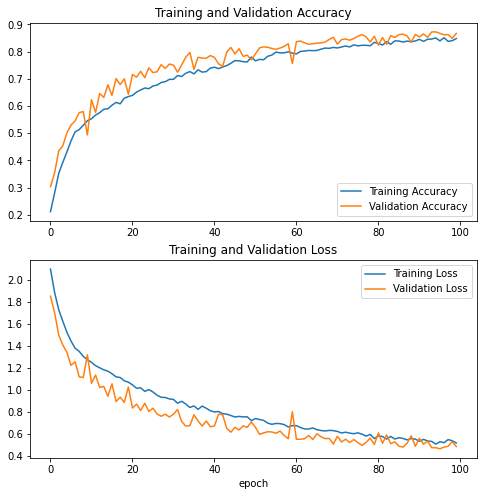

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
loss, accuracy = model.evaluate(val_datagen.flow(X_test,Y_test,batch_size=num_batch_size))
loss, accuracy1 = model.evaluate(train_datagen.flow(X_train,Y_train, batch_size=num_batch_size))
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)

191/191 [==============================] - 13s 70ms/step - loss: 0.3784 - accuracy: 0.8935
Test accuracy : 0.8786259293556213
Train accuracy : 0.8934882283210754


In [32]:
model.save('logs/soundClass_model_augmentation.h5')